# Real State Scrapy

Scrapy the real state website and retrieve house listing of a target price and retrieve the info and save to database.

### Import Dependencies

In [1]:
import os
from bs4 import BeautifulSoup
import requests
from splinter import Browser
import pandas as pd
import time
import numpy as np
import pprint


# Import DB user and password
from api_keys import positionstack_key
from api_keys import opencagedata_API
from api_keys import DATABASE_URL

### Setup Splinter (For Mac)

Check Splinter documentation for info on how to find elements:
https://splinter.readthedocs.io/en/latest/finding.html

In [2]:
# identify location of chromedriver and store it as a variable
driverPath = !which chromedriver

# Setup configuration variables to enable Splinter to interact with browser
executable_path = {'executable_path': driverPath[0]}
browser = Browser('chrome', **executable_path, headless=False)

### Scraping

In [3]:
# URL of page to be scraped
url_realtor = "https://www.realtor.com/realestateandhomes-search/Houston_TX/type-single-family-home/price-"
link_details = "https://www.realtor.com"
min_price = '200000'
max_price = '300000'
sort_by = '/sby-2' # Highest to lowest price
sort_by = '/sby-6' # Newest listings
page_number = 3

query_url = f"{url_realtor}{min_price}-{max_price}{sort_by}/pg-{page_number}"
print(query_url)

https://www.realtor.com/realestateandhomes-search/Houston_TX/type-single-family-home/price-200000-300000/sby-6/pg-3


### BeautifulSoup

In [4]:
# Scrap with BeautifulSoup. However it does 
# page = requests.get(query_url)
# soup = BeautifulSoup(page.content, 'html.parser')

### Splinter

In [5]:
# Use the browser to visit the url
browser.visit(query_url)

In [6]:
# Wait for x seconds for error purpouses
time.sleep(5)

In [7]:
# Return the rendered page by the browser
html_realtor = browser.html

In [8]:
# Use beatifulsoup to scrap the page rendered by the browser
soup = BeautifulSoup(html_realtor, 'html.parser')

In [9]:
"""
Find all lis in order to find each house item.
Then look for the class = "photo-wrap" to retrieve the unique id
for each listing. Hover the mouse over the house to load the picture and
finally get the picture link to save in the database
"""
house_ads = soup.find_all('li')
for kk in range(len(house_ads)):
    if house_ads[kk].find_all('div', class_= "photo-wrap"):
        div_tag = house_ads[kk].find('div', class_= "photo-wrap")
        browser.find_by_id(div_tag['id']).mouse_over()
        time.sleep(1)

In [10]:
# Return the rendered page by the browser after loading all photos
html_realtor = browser.html

In [11]:
# Use beatifulsoup to scrap the page rendered by the browser
soup = BeautifulSoup(html_realtor, 'html.parser')

In [12]:
# Search for the div where the title is located
results = soup.find_all('div', class_="card-box")
# print(results[0].prettify())
print(f"Total results: {len(results)}")

Total results: 48


In [13]:
# Find beds, baths, sqft and lot
def find_features(house_feat_temp):
    list_features = []
    for jj in range(len(house_feat_temp)):
        list_features.append(house_feat_temp[jj].text)

    try:
        index_pos = list_features.index("bed")
    except ValueError:
        bed = 1.0
    else:
        bed = float(list_features[index_pos-1])

    try:
        index_pos = list_features.index("bath")
    except ValueError:
        bath = 1.0
    else:
        bath = float(list_features[index_pos-1].replace("+",""))

    try:
        index_pos = list_features.index("sqft")
    except ValueError:
        sqft = np.nan
    else:
        sqft = float(list_features[index_pos-1].replace(",",""))

    try:
        index_pos = list_features.index("sqft lot")
    except ValueError:
        try:
            index_pos = list_features.index("acre lot")
        except ValueError:
            lot = np.nan
        else:
            lot = round(float(list_features[index_pos-1])*43560)    
    else:
        lot = float(list_features[index_pos-1].replace(',',''))

#     print(f"Beds: {bed}, Bath: {bath}, Sqft: {sqft}, Lot: {lot}")
    
    return {"Beds": bed, "Bath": bath, "Sqft": sqft, "Lot": lot}

find_features(results[6].find('ul').find_all('span'))

{'Beds': 5.0, 'Bath': 2.0, 'Sqft': 2157.0, 'Lot': 7192.0}

In [14]:
# Print results and save to a dictionary
n = 0
realstate_list = []
for result in results:
#     Clear the variables to not store repeated info
    house_price = ''
    address = ''
    link_page = ''
    photo_url = ''
                
    n = n + 1
    print('-----------------------------------')
    print('')
    print(f'Result: {n} of {len(results)}')
    if not result.find('div', class_="ads"):
#         print(f'Result: {n} of {len(results)}')
        price_div = result.find('div', class_="price")
        house_price = float(price_div.find('span').text.split('$')[-1].replace(",",""))
        link_page = result.find('a')['href']
        img_label = result.find('img')
        address = img_label['alt']
        
        
#         house_features = result.find('ul').text
#         list_house_features = house_features.replace("bed",";").replace("bath",";").replace("lot",";").replace("sqft",";").split(";")
#         bed = float(list_house_features[0])
#         bath = float(list_house_features[1])
#         sqft = int(list_house_features[2].replace(",",""))
#         lot = list_house_features[3]

#         # Convert acre to sqft
#         if (lot.find('acre') != -1): 
#             lot = (round(float(lot.replace('acre',''))*43560))
#         else:
#             lot = int(lot.replace(",",""))

        

        features = find_features(result.find('ul').find_all('span'))
        
        bed = features['Beds']
        bath = features['Bath']
        sqft = features['Sqft']
        lot = features['Lot']
            
        print(f"Price: ${house_price} | Beds: {bed}, Bath: {bath}, Sqft: {sqft}, Lot: {lot}")
        
        print(f"Address: {address}")
        
        try:
            price_reduced = result.find('span', class_="price-reduced-amount")
            price_now = price_reduced.text
            print(f"Price reduced: {price_now}")
        except:
            pass
        print(f"Link: {link_details}{link_page}")
#         photo_url = img_label['srcset'].split(',')[1].split(' ')[1]
        
#         try:
#             photo_url = img_label['srcset'].split(',')[1].split(' ')[1]
#             print(f"Photo link: {photo_url}")
#         except KeyError:
#             print(f"Photo not available")
            
        separator = '+'
        address_google = separator.join(address.split(" "))
        url_google_maps = f"https://www.google.com/maps/place/{address_google}"
        print(f"Google Maps: {url_google_maps}")
    
        list_images = ['', '']
        house_pictures_tag = result.find_all('picture')
        for uu in range(len(house_pictures_tag)):
            list_images[uu] = house_pictures_tag[uu].find('img')['srcset'].split(',')[1].split(' ')[1]
            print(f"Image_{uu}: {list_images[uu]}")
        
        # Save results to a dictionary
        realstate_list.append(
            {
                "Price": house_price,
                "Address": address,
                "Beds": bed,
                "Baths": bath,
                "Sqft": sqft,
                "Lot": lot,
                "Image_1": list_images[0],
                "Image_2": list_images[1],
                "Link": str(link_details+link_page),
                "Google Maps": url_google_maps
            }
        )

    
    else:
        print('Data not available or Ads')

    print('')
    
    

-----------------------------------

Result: 1 of 48
Price: $259990.0 | Beds: 3.0, Bath: 2.0, Sqft: 1630.0, Lot: nan
Address: 4419 Abaco Lane, Houston, TX 77045
Link: https://www.realtor.com/realestateandhomes-detail/Patton_Agua-Estates_4419-Abaco-Lane_Houston_TX_77045_P417000495733
Google Maps: https://www.google.com/maps/place/4419+Abaco+Lane,+Houston,+TX+77045
Image_0: https://an.rdcpix.com/9f9f7476c5d1408d32a6871a39c3172ae-f1743357976od-w480_h360_x2.jpg
Image_1: https://an.rdcpix.com/9f9f7476c5d1408d32a6871a39c3172ae-f2355931807od-w480_h360_x2.jpg

-----------------------------------

Result: 2 of 48
Price: $273990.0 | Beds: 3.0, Bath: 2.5, Sqft: 1746.0, Lot: nan
Address: 4419 Abaco Lane, Houston, TX 77045
Link: https://www.realtor.com/realestateandhomes-detail/Bradley_Agua-Estates_4419-Abaco-Lane_Houston_TX_77045_P417000495732
Google Maps: https://www.google.com/maps/place/4419+Abaco+Lane,+Houston,+TX+77045
Image_0: https://an.rdcpix.com/1caf5a5dcb66b046d7003a1df0cc05e0e-f23550706

In [15]:
# When you’ve finished testing, close your browser using browser.quit:
browser.quit()

<hr style="border: 3px solid red;">

### Data Cleaning

In [43]:
# Save the data to a dataframe
listing_df = pd.DataFrame(realstate_list)
# listing_df.to_csv(os.path.join('Database','ScrapedData.csv'))
listing_df.head(2)

,Price,Address,Beds,Baths,Sqft,Lot,Image_1,Image_2,Link,Google Maps
0,259990.0,"4419 Abaco Lane, Houston, TX 77045",3.0,2.0,1630.0,NaN,https://an.rdcpix.com/9f9f7476c5d1408d32a6871a...,https://an.rdcpix.com/9f9f7476c5d1408d32a6871a...,https://www.realtor.com/realestateandhomes-det...,https://www.google.com/maps/place/4419+Abaco+L...
1,273990.0,"4419 Abaco Lane, Houston, TX 77045",3.0,2.5,1746.0,NaN,https://an.rdcpix.com/1caf5a5dcb66b046d7003a1d...,https://an.rdcpix.com/1caf5a5dcb66b046d7003a1d...,https://www.realtor.com/realestateandhomes-det...,https://www.google.com/maps/place/4419+Abaco+L...


In [17]:
# Dataframe to dictionary
# listing_df.to_dict(orient="records")

[{'Price': 259990.0,
  'Address': '4419 Abaco Lane, Houston, TX 77045',
  'Beds': 3.0,
  'Baths': 2.0,
  'Sqft': 1630.0,
  'Lot': nan,
  'Image_1': 'https://an.rdcpix.com/9f9f7476c5d1408d32a6871a39c3172ae-f1743357976od-w480_h360_x2.jpg',
  'Image_2': 'https://an.rdcpix.com/9f9f7476c5d1408d32a6871a39c3172ae-f2355931807od-w480_h360_x2.jpg',
  'Link': 'https://www.realtor.com/realestateandhomes-detail/Patton_Agua-Estates_4419-Abaco-Lane_Houston_TX_77045_P417000495733',
  'Google Maps': 'https://www.google.com/maps/place/4419+Abaco+Lane,+Houston,+TX+77045'},
 {'Price': 273990.0,
  'Address': '4419 Abaco Lane, Houston, TX 77045',
  'Beds': 3.0,
  'Baths': 2.5,
  'Sqft': 1746.0,
  'Lot': nan,
  'Image_1': 'https://an.rdcpix.com/1caf5a5dcb66b046d7003a1df0cc05e0e-f2355070613od-w480_h360_x2.jpg',
  'Image_2': 'https://an.rdcpix.com/1caf5a5dcb66b046d7003a1df0cc05e0e-f3122543125od-w480_h360_x2.jpg',
  'Link': 'https://www.realtor.com/realestateandhomes-detail/Bradley_Agua-Estates_4419-Abaco-Lane_

<hr style="border: 3px solid red;">

## Save Scraped House Data to Database

Info about primary key auto increment even with roll back: https://stackoverflow.com/questions/449346/mysql-auto-increment-does-not-rollback

In [51]:
 # Imports the method used to connect to DBs
from sqlalchemy import create_engine
from sqlalchemy import exc
from sqlalchemy import update

# Imports the methods needed to abstract python classes into database tables
from sqlalchemy.ext.declarative import declarative_base
Base = declarative_base()

# function to establish a session with a connected database
from sqlalchemy.orm import Session

# database compliant datatypes
from sqlalchemy import Column, Integer, String, Float, ForeignKey

# from config import db_user, dialect

In [52]:
# Create database connection
engine = create_engine(DATABASE_URL) 

In [53]:
# Create class to frame each real state instance
class RealState(Base):
    __tablename__ = 'realstatelisting'

    house_id = Column(Integer, primary_key=True)
    address = Column(String(300), unique=True, nullable=False)
    price = Column(Float, nullable=False)
    bed = Column(Float, nullable=True)
    bath = Column(Float, nullable=True)
    sqft = Column(Float, nullable=True)
    lot = Column(Float, nullable=True)
    latitude = Column(Float, nullable=True)
    longitude = Column(Float, nullable=True)
    house_link = Column(String(300), nullable=True)
    image_1 = Column(String(300), nullable=True)
    image_2 = Column(String(300), nullable=True)
    map_link = Column(String(300), nullable=True)
    google_map = Column(String(300), nullable=True)

    def __repr__(self):
        return '<Listing %r>' % (self.address)

In [54]:
# Create all of the tables in our database based on the classes we've associated with our declarative base.
Base.metadata.create_all(engine)

In [23]:
# Create a Session object to connect to DB
session = Session(bind=engine)

In [24]:
""" Verify if the items are in the database to avoid roll back"""
new_entries_index = []
for nn in range(len(listing_df)):
    house_item = listing_df.iloc[nn]
    query_results = session.query(RealState).filter(RealState.address == house_item.Address).all()
    if query_results:
        pass
    else:
        new_entries_index.append(nn)

new_houses_df = listing_df.iloc[new_entries_index]
print(f"--> {len(new_houses_df)} records to be added.")

--> 40 records to be added.


In [25]:
ll = 0
for nn in range(len(new_houses_df)):
#     print('-'*25)
#     print(f"{nn+1} of {len(listing_df)}")
    house_item = new_houses_df.iloc[nn]

    new_house = RealState(
        address = house_item.Address,
        price = house_item.Price,
        bed = house_item.Beds,
        bath = house_item.Baths,
        sqft = house_item.Sqft,
        lot = house_item.Lot,
        image_1 = house_item['Image_1'],
        image_2 = house_item['Image_2'],
        house_link = house_item.Link,
        google_map = house_item['Google Maps']
        )
    
    try:
        session.add(new_house)
        session.commit()
        ll = ll + 1
    except exc.IntegrityError:
        session.rollback()
        print(f'Roll back: {new_house}')

print(f"--> Total recordes added to database: {ll}.")

--> Total recordes added to database: 40.


<hr style="border: 3px solid red;">

### Get Coordinates Using Google Maps

In [26]:
""" Get house coordinates using Splinter to scrap Google Maps """
def find_coordinates(url):
    browser = Browser('chrome', **executable_path, headless=False)
    browser.visit(url)
    time.sleep(5)
    current_url = browser.url
    browser.quit()

    try:
        latitude = float(current_url.split("!")[-2].split("d")[1])
        longitude = float(current_url.split("!")[-1].split("d")[1])
    except IndexError:
        url_string_list = current_url.split("/")
        for jj in range(len(url_string_list)):
            try:
                index_coordinates = url_string_list[jj].index("@")
            except ValueError:
                pass
            else:
                latitude = float(url_string_list[jj][1:-1].split(",")[0])
                longitude = float(url_string_list[jj][1:-1].split(",")[1])
        
    map_link = f"https://www.openstreetmap.org/?mlat={latitude}&mlon={longitude}#map=15/{latitude}/{longitude}"

    return {"latitude":latitude, "longitude":longitude, "map_link": map_link}

In [27]:
""" Query houses and update entry with coordinates and map link """
def update_house_coordinates(HouseID):
    house = session.query(RealState).filter(RealState.house_id == HouseID)
    coordinates = find_coordinates(house[0].google_map)
    stmt = update(RealState).where(RealState.house_id == HouseID).values(coordinates).\
        execution_options(synchronize_session="fetch")

    session.execute(stmt)
    session.commit()


In [28]:
# Update coordinates for all entries of the database that doesn't have coordinates
house_list = session.query(RealState).filter(RealState.latitude == None).order_by(RealState.house_id).all()
nn = 0
for house in house_list:
    update_house_coordinates(house.house_id)
    nn = nn + 1

print(f"{nn} records updated.")

40 records updated.


In [29]:
session.close()

<hr style="border: 3px solid red;">

### Query database

In [30]:
# Query all records and create a list with the returned data
query_result = session.query(RealState).all()
query_result[0:2]

[<Listing '15623 Pennfield Point Ct, Houston, TX 77044'>,
 <Listing '11202 Harbin Dr, Houston, TX 77065'>]

In [31]:
query_res = query_result[1]
print(f"house_id: {query_res.house_id}")
print(f"address: {query_res.address}")
print(f"price: {query_res.price}")
print(f"bed: {query_res.bed}")
print(f"bath: {query_res.bath}")
print(f"sqft: {query_res.sqft}")
print(f"lot: {query_res.lot}")
print(f"latitude: {query_res.latitude}")
print(f"longitude: {query_res.longitude}")
print(f"house_link: {query_res.house_link}")
print(f"image_1: {query_res.image_1}")
print(f"image_2: {query_res.image_2}")
print(f"map_link: {query_res.map_link}")
print(f"google_map: {query_res.google_map}")

house_id: 80
address: 11202 Harbin Dr, Houston, TX 77065
price: 255000.0
bed: 3.0
bath: 1.5
sqft: 1920.0
lot: 33106.0
latitude: 29.9370328
longitude: -95.5983694
house_link: https://www.realtor.com/realestateandhomes-detail/11202-Harbin-Dr_Houston_TX_77065_M73049-13400
image_1: https://ap.rdcpix.com/c6e6f9e0e1c7e698d4375467d6c95240l-m1418991769od-w480_h360_x2.jpg
image_2: https://ap.rdcpix.com/c6e6f9e0e1c7e698d4375467d6c95240l-m3579221237od-w480_h360_x2.jpg
map_link: https://www.openstreetmap.org/?mlat=29.9370328&mlon=-95.5983694#map=15/29.9370328/-95.5983694
google_map: https://www.google.com/maps/place/11202+Harbin+Dr,+Houston,+TX+77065


<hr style="border: 3px solid red;">

### Basic Analysis

In [32]:
# Query database using pandas
SQL_Query_df = pd.read_sql_query('''select * from realstatelisting''', engine)

In [39]:
SQL_Query_df.describe()

,house_id,price,bed,bath,sqft,lot,latitude,longitude
count,123.000000,123.000000,123.000000,123.000000,123.000000,106.000000,123.000000,123.000000
mean,75.983740,247396.544715,3.398374,2.272358,2001.528455,7481.330189,29.792853,-95.406693
std,53.387692,28050.927822,0.674353,0.480147,476.597475,3873.529653,0.131914,0.171732
min,1.000000,200000.000000,1.000000,1.000000,782.000000,1482.000000,29.560375,-95.700433
25%,31.500000,225000.000000,3.000000,2.000000,1645.500000,5425.000000,29.688904,-95.581143
50%,62.000000,244000.000000,3.000000,2.500000,1993.000000,7196.000000,29.764499,-95.372241
75%,135.500000,269900.000000,4.000000,2.500000,2284.500000,8403.000000,29.889297,-95.279514
max,166.000000,300000.000000,6.000000,4.000000,3192.000000,33106.000000,30.084318,-95.115706


In [33]:
SQL_Query_df.head(2)

,house_id,address,price,bed,bath,sqft,lot,latitude,longitude,house_link,image_1,image_2,map_link,google_map
0,79,"15623 Pennfield Point Ct, Houston, TX 77044",221995.0,3.0,2.0,1585.0,NaN,29.947393,-95.182588,https://www.realtor.com/realestateandhomes-det...,https://ap.rdcpix.com/d567a49777c29909ccf76cfd...,https://ap.rdcpix.com/d567a49777c29909ccf76cfd...,https://www.openstreetmap.org/?mlat=29.9473933...,https://www.google.com/maps/place/15623+Pennfi...
1,80,"11202 Harbin Dr, Houston, TX 77065",255000.0,3.0,1.5,1920.0,33106.0,29.937033,-95.598369,https://www.realtor.com/realestateandhomes-det...,https://ap.rdcpix.com/c6e6f9e0e1c7e698d4375467...,https://ap.rdcpix.com/c6e6f9e0e1c7e698d4375467...,https://www.openstreetmap.org/?mlat=29.9370328...,https://www.google.com/maps/place/11202+Harbin...


Text(0, 0.5, 'price')

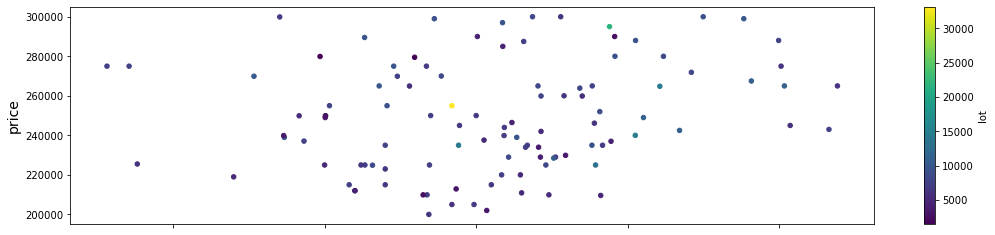

In [42]:
ax1 = SQL_Query_df.plot.scatter(x='sqft',y='price',c='lot', colormap='viridis',figsize=(18,4))
ax1.set_xlabel("sqft", fontsize=14)
ax1.set_ylabel("price", fontsize=14)

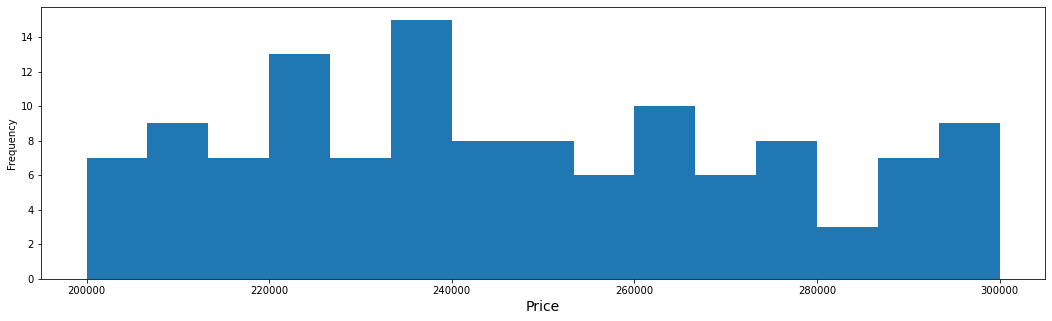

In [38]:
ax1 = SQL_Query_df['price'].plot(kind='hist',bins=15,figsize=(18,5));
ax1.set_xlabel("Price", fontsize=14);

Text(0, 0.5, 'longitude')

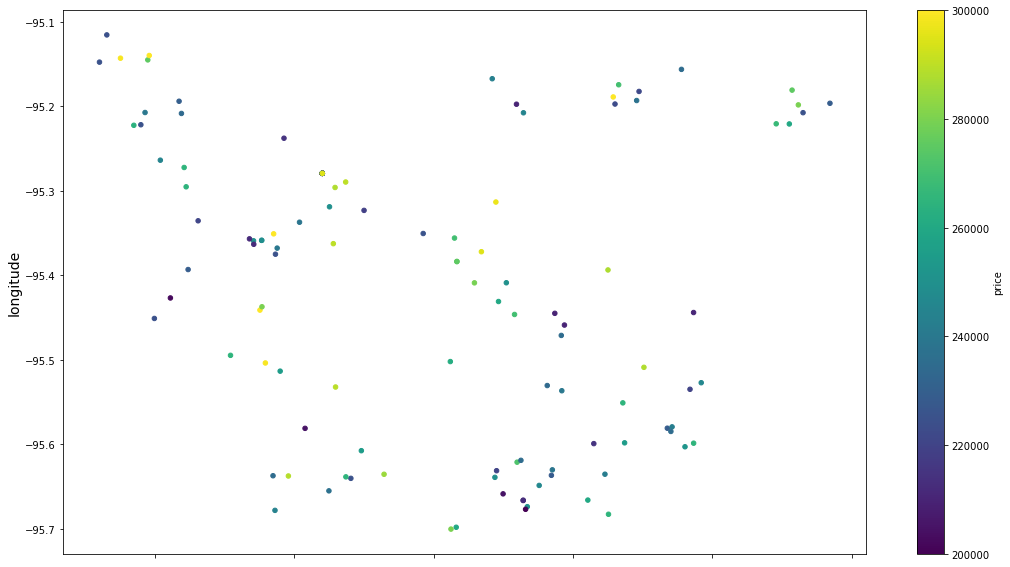

In [36]:
ax1 = SQL_Query_df.plot.scatter(x='latitude',y='longitude',c='price', colormap='viridis',figsize=(18,10))
ax1.set_xlabel("latitude", fontsize=14)
ax1.set_ylabel("longitude", fontsize=14)

In [44]:
# Create database connection
engine = create_engine(DATABASE_URL) 

In [55]:
class UserSelection(Base):
    __tablename__ = 'userselection'

    userselection_id = Column(Integer, primary_key=True)
    username = Column(String(300))
    useremail = Column(String(300))
    house_id = Column(Integer, ForeignKey('realstatelisting.house_id'))
    user_choice = Column(String(300))
    
    def __repr__(self):
        return '<Listing %r>' % (self.userselection_id)

In [56]:
# Create all of the tables in our database based on the classes we've associated with our declarative base.
Base.metadata.create_all(engine)

In [57]:
# Create a Session object to connect to DB
session = Session(bind=engine)